# Notebook comparing math/physics behind ADC compared to DTI. 
Based on notes from 2/25/22, Mira Liu

DTI: Diffusion tensor is an anisotropic 3D ellipsoid 

Diffusion Tensor is a 3x3 matrix (at minimum)
$$ D = 
\begin{pmatrix}
D_{xx} & D_{xy} & D_{xz}\\
D_{yx} & D_{yy} & D_{yz}\\
D_{zx} & D_{zy} & D_{zz}\\
\end{pmatrix}$$

These represent diffusion coefficients measured along the $(\vec{x},\vec{y},\vec{z})$ axes and the correlation between each pair. 

Eigenvalues $\lambda_1, \lambda_2, \lambda_3$ are the strenghts of the diffusion displacement along the three orthonormal eigenvectors $\vec{\epsilon_1}, \vec{\epsilon_2}, \vec{\epsilon_3}$ which represent the three principal diffusion directions. 

$D\vec{\epsilon_1} = \lambda_1\vec{\epsilon_1}$

$D\vec{\epsilon_2} = \lambda_2\vec{\epsilon_2}$

$D\vec{\epsilon_3} = \lambda_3\vec{\epsilon_3}$

These eigenvectors DO NOT NECESSARILY ALIGN WITH THE LABFRAME $(\vec{x},\vec{y},\vec{z})$

On the other hand, ADC is just the average of diffusion along the three LAB FRAME coordinates (assuming the b-values are along the lab frame, $(\vec{x},\vec{y},\vec{z})$). 

That is, for ADC along the Lab Frame Coordinates $(\vec{x},\vec{y},\vec{z})$
$$S_x = S_0 e^{-bDxx}$$
$$S_y = S_0 e^{-bDyy}$$
$$S_z = S_0 e^{-bDzz}$$

$$S_{ADC} = \sqrt[3]{S_xS_yS_z} = S_0 e^{-b(Dxx+Dyy + Dzz)/3}$$

$$ ADC = -\frac{1}{b} ln(\frac{S_{ADC}}{S_0}) = \frac{(D_{xx} + D_{yy} + D_{zz})}{3}$$


In comparison, for DTI: $$ MD = \frac{\lambda_1 + \lambda_2+ \lambda_3}{3}$$


So, the question is, if the diffusion ellipsoid axes $\vec{\epsilon_1}, \vec{\epsilon_2}, \vec{\epsilon_3}$ do NOT align with the standard lab frame axes $(\vec{x},\vec{y},\vec{z})$ does 
$$(D_{xx} + D_{yy} + D_{zz}) \approx (\lambda_1 + \lambda_2+ \lambda_3)$$


The code below checks this out, IGNORING difference in scale (i.e. voxel size, microvaculature/strucure compared to anatomic or functional patterns) or use (i.e. massive change in blood flow compared to white matter track alignment)

My suspicions: ADC will underestimate DTI MD, but at the scale and application of perfusion MRI, it is inconsequential. 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv
import scipy.optimize as op
import scipy.stats as stats
from scipy.optimize import curve_fit
import scipy.io 
from scipy.stats import rice
from mpl_toolkits.mplot3d import Axes3D

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr
from scipy.special import stdtr
import csv
import pandas as pd

import sys 
import os
#sys.path.append(os.path.abspath("/Users/neuroimaging/Desktop/MR-code/Python_Code/"))
#from Data20200706 import *

In [2]:
# So create ellipsoid, and rotate it to create eigenvalues and eigenvectors (i.e. create anisotropic diffusion ellipsoid)
# then find Diffusion tensor (knowing eigenvalues and eigenvectors from the ellipsoid)
# then compare Dxx + Dyy + Dzz to the sum of the eigenvalues? 

#also work in the ROTATED ELLIPSOID PLANE. so as if the rotated 3D orthogonal axes are "x,y,z" 
#the "lab" coordinates (i.e. MRI directions) are then rotated by thetaxyz = [thetax,thetay,thetaz] where they are all orthogonal

'''Rotations: Give angle wanted rotated to respective function, returns rotated point(s).'''

def Rx(x):
    Rx = np.matrix([[1,0,0],[0, np.cos(x), -np.sin(x)], [0, np.sin(x), np.cos(x)]])
    return Rx
def Ry(y):
    Ry = np.matrix([[np.cos(y),0,np.sin(y)],[0, 1, 0], [-np.sin(y), 0, np.cos(y)]])
    return Ry
def Rz(z):
    Rz = np.matrix([[np.cos(z), - np.sin(z), 0],[np.sin(z), np.cos(z), 0], [0, 0, 1]])
    return Rz
def Rxyz (thet):
    Rxyz = Rx(thet[0])*Ry(thet[1])*Rz(thet[2])
    return np.array(Rxyz)


#defines ellipsoid given coefficients a,b,c, center [0,0,0], and give rotation thetaxyz
def ellipsoid(abc,thetaxyz):
    a = abc[0]
    b = abc[1]
    c = abc[2]
    A = np.array([[a,0,0],[0,b,0],[0,0,c]])
    center = [0,0,0]
    eigenvectors,eigenvalues,rotated = np.linalg.svd(A) #ignore rotation as it's made in standard xyz, then will be rotated
    theta = np.linspace(0.0, np.pi, 100)
    phi = np.linspace(0.0, 2.0 * np.pi, 100)
    x = eigenvalues[0] * np.outer(np.cos(theta), np.sin(phi))
    y = eigenvalues[1] * np.outer(np.sin(theta), np.sin(phi))
    z = eigenvalues[2] * np.outer(np.ones_like(theta), np.cos(phi))

    rotation = Rxyz(thetaxyz)
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center
    return x,y,z

    
#create 3 orthogonal vectors, rotated by thetaxyz = [theta_x, theta_y, theta_z]
def OrthogVects(thetaxyz):
    xhat = [1,0,0]
    yhat = [0,1,0]
    zhat = [0,0,1]
    
    xrotated = Rxyz(thetaxyz)*xhat
    yrotated = Rxyz(thetaxyz)*yhat
    zrotated = Rxyz(thetaxyz)*zhat
    return xrotated, yrotated, zrotated
#this is jst trying to take the standard orthonormal vectors and rotate it by x,y,z around x and y and z axis... 


#this is from stackoverflow to get equal axes...https://stackoverflow.com/questions/13685386/matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
    return 


'''make_line (ML): given a point, vector, and length, makes the corresponding line '''
def ML(p,v,L):
    pointL = p
    VectL = numpy.array(v)
    Lwant = int(L)
    VectLNorm = N(v)
    t = numpy.linspace(0,Lwant,50) #make related to wanted length??
    x = [pointL[0]]
    y = [pointL[1]]
    z = [pointL[2]]
    for t in range (0,Lwant):
        L = numpy.sqrt(((VectLNorm[0]*t)**2 + (VectLNorm[2]*t)**2 + (VectLNorm[2]*t)**2))
        xL = pointL[0] + t*VectLNorm[0]
        yL = pointL[1] + t*VectLNorm[1]
        zL = pointL[2] + t*VectLNorm[2]
        if L <= Lwant:
            x.append(xL)
            y.append(yL)
            z.append(zL)
    return [x,y,z]
    


#get the average diffusion from the primary diffusion ellipsoid axes (this is lambda 1 + lambda 2 + lambda 3 divided by 3
#this can only be gotten from DTI...multiple directions.
#then rotate ellipsoid into 'lab frame' annd get the new sum of axes
#this is then Dxx + Dyy + Dzz divided by 3. 
def CompareAxes(abc,thetaxyz):
    a = abc[0]
    b = abc[1]
    c = abc[2]
    #set up innitial 3d ellipsoid
    A = np.array([[a,0,0],[0,b,0],[0,0,c]])
    center = [0,0,0]
    eigenvectors,eigenvalues,rotated = np.linalg.svd(A) #ignore 'rotated' as it's made in standard xyz, then will be rotated
    theta = np.linspace(0.0, np.pi, 100) #cover all angles to build ellipsoid
    phi = np.linspace(0.0, 2.0 * np.pi, 100)  #cover all angles to build ellipsoid
    #get major axes
    x = eigenvalues[0] * np.outer(np.cos(theta), np.sin(phi))
    y = eigenvalues[1] * np.outer(np.sin(theta), np.sin(phi))
    z = eigenvalues[2] * np.outer(np.ones_like(theta), np.cos(phi))
    
    #rotate by thetaxyz
    rotation = Rxyz(thetaxyz)
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center

    #now maybe just find the values here that are closest to the xyz LAB FRAME axes? 
    ###
    # gotta fix the meshgrid stuff... 
    Dxx,Dyy,Dzz = find_axes(x,y,z) #just get the length of the ellipsoid along the normal axis (i.e. 3 random orthogonal directions)
    ADC = (Dxx + Dyy + Dzz)/3
    DTI = (a + b + c)/3 #compare to the actual eigenvectors

    return ADC,DTI

#find the index where two values of array are closest to zero (to find axes)
#assumes x and y and z are meshgrid (2D)
def find_axes(array1, array2, array3):
    value = 0 #closest to 0
    array1 = np.asarray(array1)
    array2 = np.asarray(array2)
    idx1,idx2 = findminidx(np.abs(array2)+np.abs(array3)) #first axis (along array1)
    Xval = np.abs(array1[idx1,idx2])
    idx1,idx2 = findminidx(np.abs(array1)+np.abs(array3)) #second axis (along array2)
    Yval = np.abs(array2[idx1,idx2])
    idx1,idx2 = findminidx(np.abs(array1)+np.abs(array2)) #third axis (along array3)
    Zval = np.abs(array3[idx1,idx2])
    return Xval, Yval, Zval

def findminidx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return k//ncol, k%ncol
    

# or another way of looking at it is.... 
Is the average of the average of 3 orthogonal vectors from center to edge of ellipsoid equal to the average of the primary axes? 

so points on the ellipsoid are: $(x/a)^2 + (y/b)^2 + (c/d)^2 = 1$

what is the average distance of ALL SETS OF 3 ORTHOGONAL VECTORS from origin to the edge of the ellipsoid?

Distance between 2 3D points = $\sqrt{(x2-x1)^2+(y2-y1)^2+(z2-z1)^2}$

So in this case... as we are measuring from the center of the ellipsoid, it's just $\sqrt{x1^2+y1^2+z1^2}$
where x1, y1, and z1 represent points on the ellipsoid...

Then, we want to get sets of three [x1,y1,z1] points from intersections of orthogonal vectors... 



### now can get ellipsoid points in rotated frame (i.e. NOT LAB FRAME). The axes are the eigenvalues and eigenvectors of the diffusion ellipsoid. 
### want to now get 3 LAB FRAME VECTORS and find their [x1,y1,z1] points on their ellipsoid and their average. (this is Dxx + Dyy + Dzz)

The eigenvalues[0] + eigenvalues[1] + eigenvalues[2] is the sum of lambdas from DTI. (see notes on 2/25)


To do this.... rotate the ellipsoid into THE LAB FRAME. then get the x, y, and z of the LAB FRAME COORDINATES. the sum of those is equal to Dxx + Dyy + Dzz.


# This is done below: 

# representing ellipsoid parameterized in spherical coordinates where ellipsoid axes coincide with coordinate axes

$$ x = a\sin(\theta)\cos(\phi)$$
$$ y = b\sin(\theta)\sin(\phi)$$
$$ z = c \cos(\theta)$$

where:

$0 \le \theta \le \pi$ and $0 \le \phi \le 2\pi$

$\theta$ is the polar angle and $\phi$ is the azimuthal angle of the point

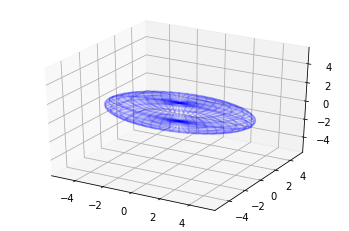

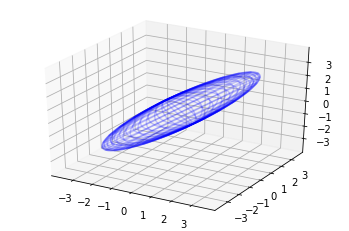

In [3]:
#set up first ellipsoid, where lab system and diffusion ellipsoid ARE IN SAME FRAME. 
abc = [1,3,5]
thetaxyz = [0,0,0]
x,y,z = ellipsoid(abc,thetaxyz)
# plot
fig = pl.figure()
ax = fig.add_subplot(111,projection='3d')
#ax.set_aspect('equal')
ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)
set_axes_equal(ax)
pl.show()
#ADC,DTI = CompareAxes(abc,thetaxyz)
#print(ADC, DTI)

#now compare to another ellipsoid, rotated now! SO NO LONGER SAME FRAME
abc2 = [1,3,5]
thetaxyz2= [0,np.pi/4,0]
x,y,z = ellipsoid(abc2,thetaxyz2)
# plot
fig = pl.figure()
ax = fig.add_subplot(111,projection='3d')
#ax.set_aspect('equal')
ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)
set_axes_equal(ax)
pl.show()

#ADC2,DTI2 = CompareAxes(abc2,thetaxyz2)
#print(ADC2,DTI2)


# Now that it seems the code works, now running statistical simulations. 


based on the paper here:
http://www.ajnr.org/content/27/2/440, Average fractional anisotropy (which can go from 0, isotropic to 1, all in one direction) is normally distributed $N(\mu = .237, \sigma = .017)$
where $$ FA = \sqrt{\frac{3}{2}} \frac{\sqrt{ (\lambda_1 - \lambda)^2 + (\lambda_2 - \lambda)^2 + (\lambda_3 - \lambda)^2}}{\sqrt{\lambda_1^2 + \lambda_2^2 + \lambda_3^2}}$$

where $\lambda$ is the MD.

Also assuming that orientation is fairly equally likely... WHICH I KNOW IT ISN'T, BUT I DON'T KNOW THE DISTRIBUTION OF ORIENTATION IN THE BRAIN... And MD ~ 1e-3. 

Also just to normalize let's make $\lambda_1 = 1$...
So trying to find the (a,b,c) that lead to the normal distribution of FA.




In [3]:
def FA(a,b,c):
    MD = (a+b+c)/3
    num = np.sqrt((a-MD)**2 + (b-MD)**2 + (c-MD)**2)
    denom = np.sqrt(a**2 + b**2 + c**2)
    return np.sqrt(3/2)*num/denom

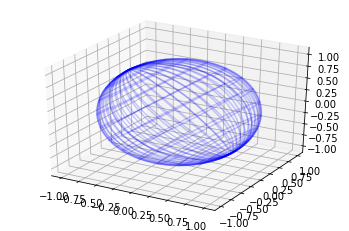

0.0


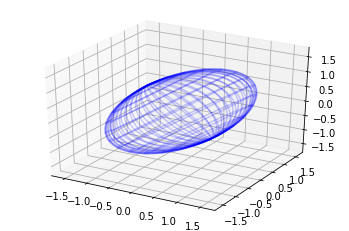

0.408248290463863


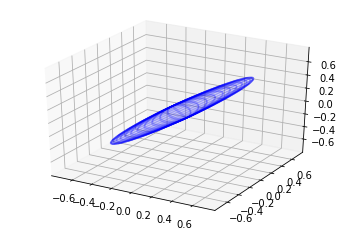

0.8911327886790067


In [6]:
abc1 = [1,1,1]
thetaxyz1= [0,np.pi/4,0]#[0,0,0]
x,y,z = ellipsoid(abc1,thetaxyz1)
# plot
fig = pl.figure()
ax = fig.add_subplot(111,projection='3d')
#ax.set_aspect('equal')
ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)
set_axes_equal(ax)
#pl.savefig('/Users/neuroimaging/Desktop/Ellipsoid_FA0.png',format='png',dpi=120)

pl.show()
print(FA(abc1[0],abc1[1],abc1[2]))

abc2 = [1,2,1]
thetaxyz1= [0,np.pi/4,0]#[0,0,0]
x,y,z = ellipsoid(abc2,thetaxyz1)
fig = pl.figure()
ax = fig.add_subplot(111,projection='3d')
#ax.set_aspect('equal')
ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)
set_axes_equal(ax)
#pl.savefig('/Users/neuroimaging/Desktop/Ellipsoid_FA41.png',format='png',dpi=120)
pl.show()
print(FA(abc2[0],abc2[1],abc2[2]))


abc3 = [1,.1,.1]
thetaxyz1= [0,np.pi/4,0]#[0,0,0]
x,y,z = ellipsoid(abc3,thetaxyz1)
fig = pl.figure()
ax = fig.add_subplot(111,projection='3d')
#ax.set_aspect('equal')
ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)
set_axes_equal(ax)
#pl.savefig('/Users/neuroimaging/Desktop/Ellipsoid_FA89.png',format='png',dpi=120)
pl.show()
print(FA(abc3[0],abc3[1],abc3[2]))



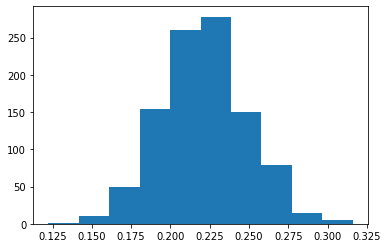

0.22157348358639642 0.026932922075465205
well, this is the random distribution of a,b,c that I will use then


In [6]:
a = 1
b = np.random.normal(1.5,.15,1000)
c = np.random.normal(1.5,.1,1000)
FAs = []
for i in range(1000):
    FAs.append(FA(a,b[i],c[i]))
    
pl.hist(FAs)
pl.show()
print(np.mean(FAs), np.std(FAs))

print('well, this is the random distribution of a,b,c that I will use then')

In [7]:
n = 1000

a = 1
b = np.random.normal(1.5,.15,n)
c = np.random.normal(1.5,.1,n)
thetax = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)
thetay = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)
thetaz = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)

ADC_all = []
DTI_all = []
for i in range(1000):
    abc = [a,b[i],c[i]]
    thetaxyz = [thetax[i],thetay[i],thetaz[i]]
    #x,y,z = ellipsoid(abc,thetaxyz)
    ADC,DTI = CompareAxes(abc,thetaxyz)
    ADC_all.append(ADC)
    DTI_all.append(DTI)
    

    
    

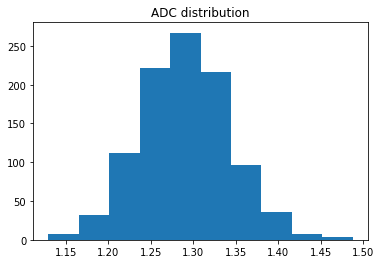

ADC stats:  1.289635640853237 0.05225993260790573


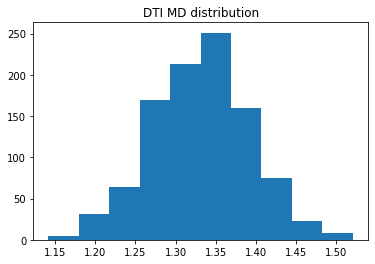

DTI stats:  1.3318051412715295 0.060952754040783465


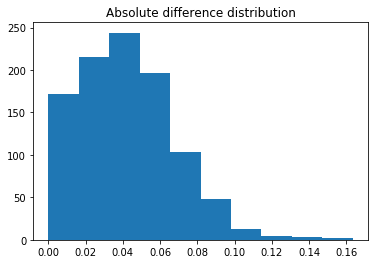

Absolute Difference stats:  0.04216950041829226 0.025397292023450965


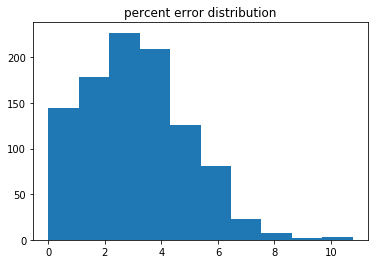

Percent Error stats:  3.127473860464463 1.7925920488146538


In [8]:
pl.hist(ADC_all)
pl.title('ADC distribution')
pl.show()
print('ADC stats: ', np.mean(ADC_all), np.std(ADC_all))

pl.hist(DTI_all)
pl.title('DTI MD distribution')
pl.show()
print('DTI stats: ', np.mean(DTI_all), np.std(DTI_all))

difference = np.array(DTI_all)-np.array(ADC_all)
pl.hist(difference)
pl.title('Absolute difference distribution')
pl.show()
print('Absolute Difference stats: ', np.mean(difference), np.std(difference))

PercentErr = 100*(difference)/(np.array(DTI_all))
pl.hist(PercentErr)
pl.title('percent error distribution')
pl.show()
print('Percent Error stats: ', np.mean(PercentErr), np.std(PercentErr))




# from the above, running 1000 cases comparing ADC to DTI MD, it seems there is statistical difference, but it is less than expected!!! 

This is done using an set of primary eigenvalues chosen to match an approximately normal distribution of FA of .237 $\pm$ .017... 

Using these, and random uniformly sampled rotation about the three axes, I calculate the ADC and the DTI. 
The everage distance is .04$\pm$.026.

# Then as percent error, this is about 3.15%$\pm$1.89% error of ADC compared to DTI MD. 


# Trying the above but with new average and std for FA (from paper, not AJNR)

https://pubmed.ncbi.nlm.nih.gov/21640837/

This is for WM only...??? it seems?  

https://www.researchgate.net/publication/49942624_Diffusion_tensor_imaging_differences_relate_to_memory_deficits_in_diffuse_traumatic_brain_injury 

also thsi is different, has much smaller distirbution
is there any FA of all parts of brain or is it mainly just WM? 


http://www.ajnr.org/content/28/2/226 


or this one?? also only WM?

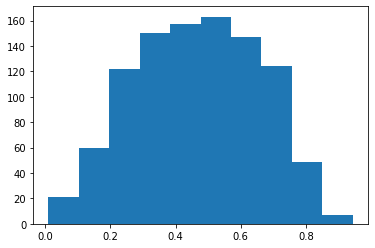

0.46834946755415935 0.18978465385993412
well, this is the random distribution of a,b,c that I will use then


In [4]:
a = 1
b = np.random.random(1000)*3 
c = np.random.random(1000)*2
FAs = []
for i in range(1000):
    FAs.append(FA(a,b[i],c[i]))
    
pl.hist(FAs)
pl.show()
print(np.mean(FAs), np.std(FAs))

print('well, this is the random distribution of a,b,c that I will use then')

In [5]:
n = 5000

a = 1
b = np.random.random(n)*3 
c = np.random.random(n)*2

thetax = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)
thetay = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)
thetaz = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)

ADC_all = []
DTI_all = []
for i in range( n):
    abc = [a,b[i],c[i]]
    thetaxyz = [thetax[i],thetay[i],thetaz[i]]
    #x,y,z = ellipsoid(abc,thetaxyz)
    ADC,DTI = CompareAxes(abc,thetaxyz)
    ADC_all.append(ADC)
    DTI_all.append(DTI)
    


   

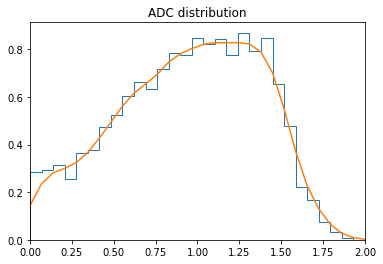

ADC stats:  0.9428060474294889 0.42041483984391


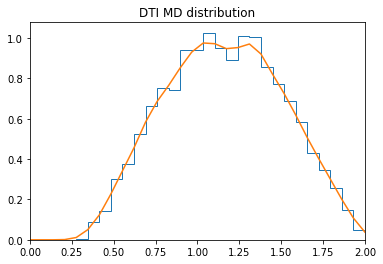

DTI stats:  1.1594509190208202 0.3493205525691831


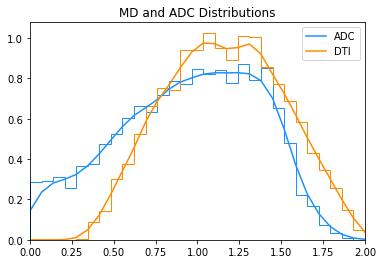

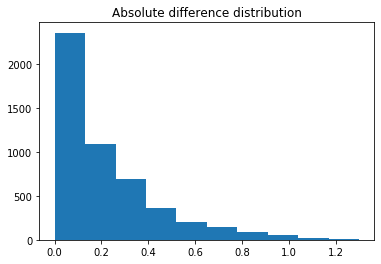

Absolute Difference stats:  0.21664487159133142 0.2226848217067665


In [7]:
  
n,x,_ = pl.hist(ADC_all,bins = np.linspace(0,2,30), density=True,histtype=u'step')
density_ADC = stats.gaussian_kde(ADC_all)
pl.plot(x, density_ADC(x))
pl.xlim([0,2])
pl.title('ADC distribution')
pl.savefig('/Users/neuroimaging/Desktop/ADCdist.png',dpi =180)
pl.show()
print('ADC stats: ', np.mean(ADC_all), np.std(ADC_all))

n,x,_ = pl.hist(DTI_all,bins = np.linspace(0,2,30), density=True,histtype=u'step')
density_DTI = stats.gaussian_kde(DTI_all)
pl.plot(x, density_DTI(x))
pl.xlim([0,2])
pl.title('DTI MD distribution')
pl.savefig('/Users/neuroimaging/Desktop/DTIdist.png',dpi =180)
pl.show()
print('DTI stats: ', np.mean(DTI_all), np.std(DTI_all))

n,x,_ = pl.hist(ADC_all,bins = np.linspace(0,2,30), density=True,histtype=u'step', color = 'dodgerblue')
pl.plot(x, density_ADC(x),color = 'dodgerblue',label = 'ADC')
n,x,_ = pl.hist(DTI_all,bins = np.linspace(0,2,30), density=True,histtype=u'step', color = 'darkorange')
pl.plot(x, density_DTI(x),color = 'darkorange', label = 'DTI')
pl.title('MD and ADC Distributions')
pl.xlim([0,2])
pl.legend()
pl.savefig('/Users/neuroimaging/Desktop/ADCMDoverlaidDistribution.png',dpi =180)
pl.show()


difference = np.array(DTI_all)-np.array(ADC_all)
pl.hist(difference)
pl.title('Absolute difference distribution')
pl.show()
print('Absolute Difference stats: ', np.mean(difference), np.std(difference))


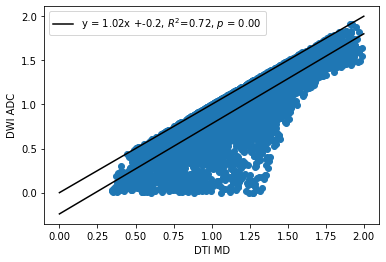

In [22]:
pl.scatter(DTI_all,ADC_all)
x = np.linspace(0,2)
pl.plot(x,x,color = 'black')
pl.xlabel('DTI MD')
pl.ylabel('DWI ADC')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(DTI_all,ADC_all)
r_value2 = r_value**2
pl.plot(x,func(x,slope,intercept),label = f'y = {slope:.2f}x +{intercept: .1f}, $R^2$={r_value2:.2f}, $p$ = {p_value:.2f}',color = 'black') 
pl.legend()
pl.show()

# This suggests a potential average -24$\pm$ 22% underestimation of anisotropy for ADC compared to truth. But with a median of 11% error.

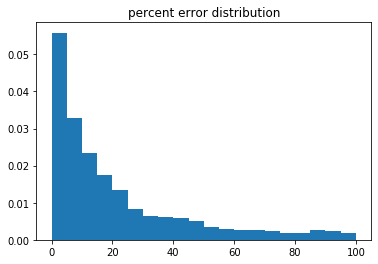

Percent Error stats:  12.099390003256612 21.13958247853854 23.418800385320527


In [8]:
PercentErr = 100*(difference)/(np.array(DTI_all))
pl.hist(PercentErr, bins = 20, density = True)
pl.title('percent error distribution')

pl.savefig('/Users/neuroimaging/Desktop/PEdist.png',dpi =180)
pl.show()
print('Percent Error stats: ', np.median(PercentErr), np.mean(PercentErr), np.std(PercentErr))




# Added wilcoxon

In [15]:
scipy.stats.ttest_ind(ADC_all,DTI_all)
#scipy.stats.wilcoxon(ADC_all,DTI_all)
#scipy.stats.ranksums(ADC_all,DTI_all)


Ttest_indResult(statistic=-28.023279221405023, pvalue=2.039383324176768e-166)

# Now need to compare it to DTI. 


Simulate DTI here... 

#get the average diffusion from the primary diffusion ellipsoid axes (this is lambda 1 + lambda 2 + lambda 3 divided by 3
#this can only be gotten from DTI...multiple directions.
#then rotate ellipsoid into 'lab frame' annd get the new sum of axes
#this is then Dxx + Dyy + Dzz divided by 3. 
def CompareAxes_DTInADC(abc,thetaxyz):
    a = abc[0]
    b = abc[1]
    c = abc[2]
    #set up innitial 3d ellipsoid
    A = np.array([[a,0,0],[0,b,0],[0,0,c]])
    center = [0,0,0]
    eigenvectors,eigenvalues,rotated = np.linalg.svd(A) #ignore 'rotated' as it's made in standard xyz, then will be rotated
    theta = np.linspace(0.0, np.pi, 100) #cover all angles to build ellipsoid
    phi = np.linspace(0.0, 2.0 * np.pi, 100)  #cover all angles to build ellipsoid
    #get major axes
    x = eigenvalues[0] * np.outer(np.cos(theta), np.sin(phi))
    y = eigenvalues[1] * np.outer(np.sin(theta), np.sin(phi))
    z = eigenvalues[2] * np.outer(np.ones_like(theta), np.cos(phi))
    
    #rotate by thetaxyz
    rotation = Rxyz(thetaxyz)
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center

    #now maybe just find the values here that are closest to the xyz LAB FRAME axes? 
    ###
    # gotta fix the meshgrid stuff... 
    Dxx,Dyy,Dzz = find_axes(x,y,z) #just get the length of the ellipsoid along the normal axis (i.e. 3 random orthogonal directions)
    ADC = (Dxx + Dyy + Dzz)/3
    Original = (a + b + c)/3 # compare to the actual eigenvectors
    
    # Now also have to choose say 10 directions, from that get diffusion tensor, and solve it?
    # reset original ellipsoid
    x = eigenvalues[0] * np.outer(np.cos(theta), np.sin(phi))
    y = eigenvalues[1] * np.outer(np.sin(theta), np.sin(phi))
    z = eigenvalues[2] * np.outer(np.ones_like(theta), np.cos(phi))
    #set 10 different directions
    thetax_DTI = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 10)
    thetay_DTI = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 10)
    thetaz_DTI = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = 10)
    Sum_MD = 0
    for k in range(10):
        rotation = Rxyz([thetax_DTI[k],thetay_DTI[k],thetaz_DTI[k]])
        for i in range(len(x)):
            for j in range(len(x)):
                [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center
        MDxx,MDyy,MDzz = find_axes(x,y,z)
        Sum_MD = Sum_MD + MDxx + MDyy + MDzz # adding up all measured directions
    MD = Sum_MD/30 # now average of the MDs
    
    return ADC, MD, Original




n = 500

a = 1
b = np.random.random(n)*3 
c = np.random.random(n)*2

thetax = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)
thetay = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)
thetaz = np.random.default_rng().uniform(low = 0, high = 2*np.pi, size = n)

ADC_all = []
DTI_all = []
MD_all = []
for i in range( n):
    abc = [a,b[i],c[i]]
    thetaxyz = [thetax[i],thetay[i],thetaz[i]]
    #x,y,z = ellipsoid(abc,thetaxyz)
    ADC,MD, DTI = CompareAxes_DTInADC(abc,thetaxyz)
    ADC_all.append(ADC)
    DTI_all.append(DTI)
    MD_all.append(MD)
    
pl.hist(ADC_all)
pl.title('ADC distribution')
pl.show()
print('ADC stats: ', np.mean(ADC_all), np.std(ADC_all))

pl.hist(DTI_all)
pl.title(' True DTI distribution')
pl.show()
print('DTI stats: ', np.mean(DTI_all), np.std(DTI_all))

pl.hist(MD_all)
pl.title(' MD distribution')
pl.show()
print('MD stats: ', np.mean(MD_all), np.std(MD_all))

difference = np.array(DTI_all)-np.array(ADC_all)
pl.hist(difference)
pl.title('ADC Absolute difference distribution')
pl.show()
print('ADC Absolute Difference stats: ', np.mean(difference), np.std(difference))

PercentErr = 100*(difference)/(np.array(DTI_all))
pl.hist(PercentErr)
pl.title('ADC percent error distribution')
pl.show()
print('ADC Percent Error stats: ', np.median(PercentErr), np.mean(PercentErr), np.std(PercentErr))

difference = np.array(DTI_all)-np.array(MD_all)
pl.hist(difference)
pl.title('MD Absolute difference distribution')
pl.show()
print('MD Absolute Difference stats: ', np.mean(difference), np.std(difference))

PercentErr = 100*(difference)/(np.array(DTI_all))
pl.hist(PercentErr)
pl.title('MD percent error distribution')
pl.show()
print('MD Percent Error stats: ', np.median(PercentErr), np.mean(PercentErr), np.std(PercentErr))


   